# Contents and why we need this lab

This lab is about implementing neural networks yourself before we start using other frameworks that hide some computation from you. It builds on the first lab, where you derived the equations for neural network forward and backward propagation and gradient descent parameter updates. 

All the frameworks for deep learning you will meet from now on use automatic differentiation (autodiff), so you do not have to code the backward step yourself. In this version of this lab, you will develop your own autodif implementation. We also have an optional [version](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/2_Feedforward_Python/2.2-FNN-NumPy.ipynb) of this lab where you have to code the backward pass explicitly in NumPy.

# External sources of information

1. Jupyter notebook. You can find more information about Jupyter notebooks [here](https://jupyter.org/). It will come as part of the [Anaconda](https://www.anaconda.com/) Python installation. 
2. [NumPy](https://numpy.org/). Part of Anaconda distribution.  If you already know how to program, most things about Python and NumPy can be found with Google searches.
3. [Nanograd](https://github.com/rasmusbergpalm/nanograd) is a minimalistic version of autodiff developed by [Rasmus Berg Palm](https://rasmusbergpalm.github.io) that we use for our framework.


# This notebook will follow the next steps:

1. Nanograd automatic differentiation framework
2. Finite difference method
3. Data generation
4. Defining and initializing the network
5. Forward pass
6. Training loop 
7. Testing your model
8. Further extensions

# Nanograd automatic differention framework

The [Nanograd](https://github.com/rasmusbergpalm/nanograd) framework defines a class Var which both holds a value and gradient value that we can use to store the intermediate values when we apply the chain rule of differentiation.

In [403]:
# Copy and pasted from https://github.com/rasmusbergpalm/nanograd/blob/3a1bf9e9e724da813bfccf91a6f309abdade9f39/nanograd.py

import math

class Var:
    """
    A variable which holds a float and enables gradient computations.
    """

    def __init__(self, val: float, grad_fn=lambda: []):
        assert type(val) == float
        self.v = val
        self.grad_fn = grad_fn
        self.grad = 0.0

    def backprop(self, bp):
        self.grad += bp
        for input, grad in self.grad_fn():
            input.backprop(grad * bp)

    def backward(self):
        self.backprop(1.0)

    def __add__(self: 'Var', other: 'Var') -> 'Var':
        return Var(self.v + other.v, lambda: [(self, 1.0), (other, 1.0)])

    def __mul__(self: 'Var', other: 'Var') -> 'Var':
        return Var(self.v * other.v, lambda: [(self, other.v), (other, self.v)])

    def __pow__(self, power):
        assert type(power) in {float, int}, "power must be float or int"
        return Var(self.v ** power, lambda: [(self, power * self.v ** (power - 1))])

    def __neg__(self: 'Var') -> 'Var':
        return Var(-1.0) * self

    def __sub__(self: 'Var', other: 'Var') -> 'Var':
        return self + (-other)

    def __truediv__(self: 'Var', other: 'Var') -> 'Var':
        return self * other ** -1

    def __repr__(self):
        return "Var(v=%.4f, grad=%.4f)" % (self.v, self.grad)

    def relu(self):
        return Var(self.v if self.v > 0.0 else 0.0, lambda: [(self, 1.0 if self.v > 0.0 else 0.0)])
    
    ## solution for ex f
    def sigmoid(self) -> 'Var':
        sig = 1 / (1.0 + math.exp(-self.v))
        return Var(sig, lambda: [(self, sig * (1 - sig))])

    def tanh(self) -> 'Var':
        tanh_val = math.tanh(self.v)
        return Var(tanh_val, lambda: [(self, 1 - tanh_val ** 2)])

    def identity(self) -> 'Var':
        return Var(self.v, lambda: [(self, 1.0)])

A few examples illustrate how we can use this:

In [404]:
a = Var(3.0)
b = Var(5.0)
f = a * b

f.backward()

for v in [a, b, f]:
    print(v)

Var(v=3.0000, grad=5.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)


In [405]:
a = Var(3.0)
b = Var(5.0)
c = a * b
d = Var(9.0)
e = a * d
f = c + e

f.backward()

for v in [a, b, c, d, e, f]:
    print(v)

Var(v=3.0000, grad=14.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)
Var(v=9.0000, grad=3.0000)
Var(v=27.0000, grad=1.0000)
Var(v=42.0000, grad=1.0000)


## Exercise a) What is being calculated?

Explain briefly the output of the code? What is the expression we differentiate and with respect to what variables?

# Solution a

In the code above, the values of `a`,`b` and `d` are defined, whereas the `c`,`e`and `f` are defined equation:

$$
where,
f = (a * b) + (a * d)
$$
Partial differentation `f `is calculated with respect to the varibles `a`
$$ 
\frac{\partial f}{\partial a} = \frac{\partial}{\partial a} {(a * b) + (a * d)}
$$
$$
= (b + d) = 5 + 9   
= 14.0
$$
The value of `a` being `3.0` here and the gradiant as `14.0`----(1)

Accordingly Partial differentation `f `is calculated with respect to the varibles `b`
$$
\frac{\partial f}{\partial b} = \frac{\partial}{\partial b} {(a * b) + (a * d)}
$$
$$
= (a + 0)   
= 3.0
$$
The value of `b` being `5.0` here and the gradiant as `3.0`----(2)  
For the partial differentaition of `f` with respect to `c`, where $c = a * b$  
$$
\frac{\partial f}{\partial c } = \frac{\partial}{\partial b} {(c) + (a * d)}  
   = 1 + 0
$$
the value of `c` being `15.0` here and the gradiant as `1.0`----(3)
* Hence the expression `f.backward` calculates the partial differentiation of `f` w.r.t the variables giving the value of equation and the partial derivative of it.  
whic can be seen as
$$
Var(v=42.0000, grad=1.0000)
$$

## Exercise b) How does the backward function work?

You need to understand how the backward function calculates the gradients. We can use the two examples above to help with that.

Go through the following four steps and answer the questions on the way:

1. We represent the two expressions as graphs as shown below. Fill in the missing expressions for the different derivatives.

2. In the remainder, consider the first expression. Make a schematic of the data structure generated when we define the expression for f (e.g., write a list of which objects are created and the corresponding values of their member variables).

3. Then execute the backward function by hand to convince yourself that it indeed calculates the gradients with respect to the variables. 

4. Write down the sequence of calls to backprop.

In [406]:
# If you have not installed networkx and matplotlib, you can install them by running
# !pip install networkx matplotlib

import networkx as nx
import matplotlib.pyplot as plt

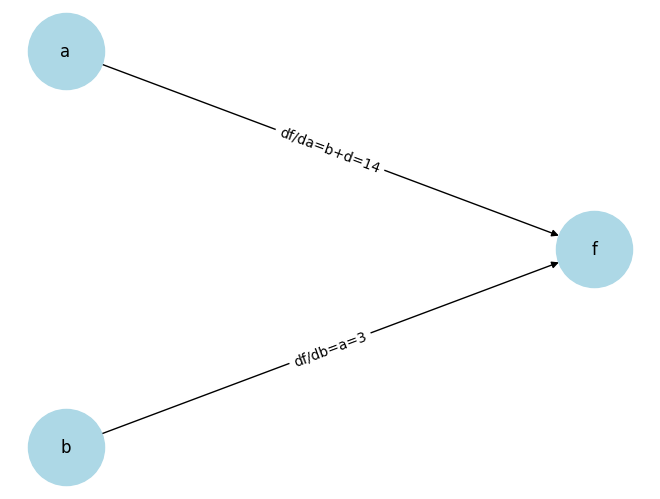

In [407]:
# Create a directed graph
G = nx.DiGraph()

# Add edges with labels
G.add_edge('a', 'f', label='df/da=b+d=14')
G.add_edge('b', 'f', label='df/db=a=3')

# Manually define positions for a tree layout
pos = {
    'a': (0, 1),
    'b': (0, -1),
    'f': (1, 0),
}
# Draw the graph nodes and edges
nx.draw(G, pos, with_labels=True, node_shape='o', node_size=3000, node_color='lightblue', arrows=True)

# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Show the plot
plt.show()

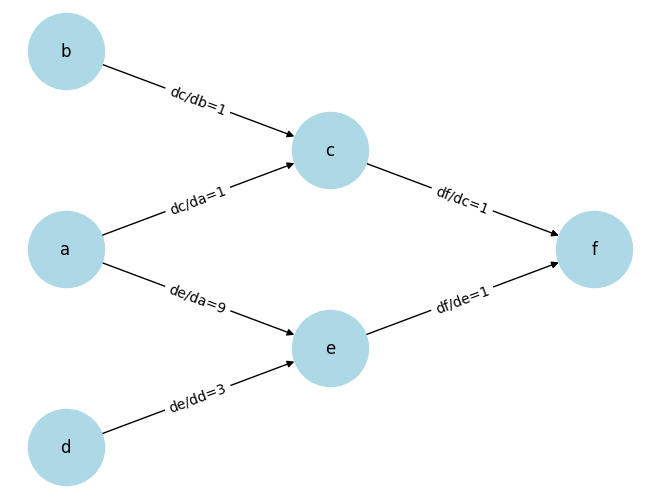

In [408]:
# Create a directed graph
G = nx.DiGraph()

# Add edges with labels
G.add_edge('a', 'c', label='dc/da=1')
G.add_edge('b', 'c', label='dc/db=1')
G.add_edge('a', 'e', label='de/da=9')
G.add_edge('d', 'e', label='de/dd=3')
G.add_edge('c', 'f', label='df/dc=1')
G.add_edge('e', 'f', label='df/de=1')

# Manually define positions for a tree layout
pos = {
    'a': (0, 0),
    'b': (0, 2),
    'c': (1, 1),
    'd': (0, -2),
    'e': (1, -1),
    'f': (2, 0)
}

# Draw the graph nodes and edges
nx.draw(G, pos, with_labels=True, node_shape='o', node_size=3000, node_color='lightblue', arrows=True)

# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Show the plot
plt.show()

## Exercise c) What happens if we run backward again?

Try to execute the code below. Explain what happens.

In [409]:
f.backward()

for v in [a, b, c, d, e, f]:
    print(v)

Var(v=3.0000, grad=28.0000)
Var(v=5.0000, grad=6.0000)
Var(v=15.0000, grad=2.0000)
Var(v=9.0000, grad=6.0000)
Var(v=27.0000, grad=2.0000)
Var(v=42.0000, grad=2.0000)


## solution c

If the backward function is exculated again the gradiant instead of values getting reset, it accumulates the value of grad and add it to the excisiting gradiant


## Exercise d) Zero gradient

We can zero the gradient by backpropagating a -1.0 as is shown in the example below. (If you have run backward multiple time then you also have to run the cell below an equal amount of times.) Explain what is going on.

In [410]:
a = Var(2.0)

for v in [a, b, c, d, e, f]:
    print(v)

f.backprop(-1.0)

for v in [a, b, c, d, e, f]:
    print(v)

Var(v=2.0000, grad=0.0000)
Var(v=5.0000, grad=6.0000)
Var(v=15.0000, grad=2.0000)
Var(v=9.0000, grad=6.0000)
Var(v=27.0000, grad=2.0000)
Var(v=42.0000, grad=2.0000)
Var(v=2.0000, grad=0.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)
Var(v=9.0000, grad=3.0000)
Var(v=27.0000, grad=1.0000)
Var(v=42.0000, grad=1.0000)


## solution d
In this example where `f.backprop(-1)` zeros the gradiant the first time we exculate the cell and then goes on subtracting the grad from the current stored value.   
Apart from that, it is evident in the  code `Nanograd` that `backwards` calls  `backprop`, which is by default set to `1`.  
We have now set it to `-1`, which allows for backpropagating tracing the grad values.   
I hope it will be use to find the slope of the error curve, which should be zero to make it perpendicular to the axis and get minimum error value.


## Exercise e) Test correctness of derivatives with the finite difference method

Write a small function that uses [the finite difference method](https://en.wikipedia.org/wiki/Finite_difference_method) to numerically test that backpropation implementation is working. In short we will use
$$
\frac{\partial f(a)}{\partial a} \approx \frac{f(a+da)-f(a)}{da}
$$
for $da \ll 1$.

As an example, we could approximate the derivative of the function $f(a)=a^2$ in e.g. the value $a=4$ using the finite difference method. This amounts to inserting the relevant values and approximating the gradient $f'(4)$ with the fraction above. 


In [411]:
# f function - try to change the code to test other types of functions as well (such as different polynomials etc.)
def f_function(a):
  a = Var(a)
  b = Var(5.0)

  f = a**2 + b*a 

  f.backward()
  return a,b,f

for v in f_function(3.0):
  print(v)

# Insert your finite difference code here
def finite_difference(da=1e-10):
    """
    This function compute the finite difference between
    
    Input:
    da:          The finite difference                           (float)
    
    Output:
    finite_difference: numerical approximation to the derivative (float) 
    """
    a = 3.0
    b = 5.0

    fa_da = (a + da)**2 + b*(a + da)  
    fa = a**2 + b*a 

    finite_difference = (fa_da - fa) / da
    
    return finite_difference

print(finite_difference())

Var(v=3.0000, grad=11.0000)
Var(v=5.0000, grad=3.0000)
Var(v=24.0000, grad=1.0000)
10.999983146575687


## solution e 
Implemented the function $ a^2 + b*a$  
The value of 
$$
\frac{\partial  }{\partial a}a^2 + b*a = 11 ------grad
$$ 

while the `finite difference method` give a value of `10.999983146575687`


# Create an artificial dataset to play with

We create a non-linear 1d regression task. The generator supports various noise levels and it creates train, validation and test sets. You can modify it yourself if you want more or less challenging tasks.

In [412]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

In [413]:
def data_generator(noise=0.1, n_samples=300, D1=True):
    # Create covariates and response variable
    if D1:
        X = np.linspace(-3, 3, num=n_samples).reshape(-1,1) # 1-D
        np.random.shuffle(X)
        y = np.random.normal((0.5*np.sin(X[:,0]*3) + X[:,0]), noise) # 1-D with trend
    else:
        X = np.random.multivariate_normal(np.zeros(3), noise*np.eye(3), size = n_samples) # 3-D
        np.random.shuffle(X)    
        y = np.sin(X[:,0]) - 5*(X[:,1]**2) + 0.5*X[:,2] # 3-D

    # Stack them together vertically to split data set
    data_set = np.vstack((X.T,y)).T
    
    train, validation, test = np.split(data_set, [int(0.35*n_samples), int(0.7*n_samples)], axis=0)
    
    # Standardization of the data, remember we do the standardization with the training set mean and standard deviation
    train_mu = np.mean(train, axis=0)
    train_sigma = np.std(train, axis=0)
    
    train = (train-train_mu)/train_sigma
    validation = (validation-train_mu)/train_sigma
    test = (test-train_mu)/train_sigma
    
    x_train, x_validation, x_test = train[:,:-1], validation[:,:-1], test[:,:-1]
    y_train, y_validation, y_test = train[:,-1], validation[:,-1], test[:,-1]

    return x_train, y_train,  x_validation, y_validation, x_test, y_test

In [414]:
D1 = True
x_train, y_train,  x_validation, y_validation, x_test, y_test = data_generator(noise=0.5, D1=D1)

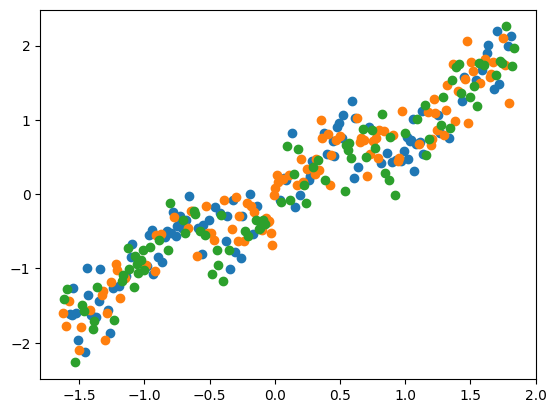

In [415]:
if D1:
    plt.scatter(x_train[:,0], y_train);
    plt.scatter(x_validation[:,0], y_validation);
    plt.scatter(x_test[:,0], y_test);
else:
    plt.scatter(x_train[:,1], y_train);
    plt.scatter(x_validation[:,1], y_validation);
    plt.scatter(x_test[:,1], y_test);
plt.show()

In [416]:
# convert from nparray to Var
def nparray_to_Var(x):
  if x.ndim==1:
    y = [[Var(float(x[i]))] for i in range(x.shape[0])] # always work with list of list
  else:
    y = [[Var(float(x[i,j])) for j in range(x.shape[1])] for i in range(x.shape[0])]
  return y
   
x_train = nparray_to_Var(x_train)
y_train = nparray_to_Var(y_train)
x_validation = nparray_to_Var(x_validation)
y_validation = nparray_to_Var(y_validation)
x_test = nparray_to_Var(x_test)
y_test = nparray_to_Var(y_test)


# Defining and initializing the network

The steps to create a feed forward neural network are the following:

1. **Number of hidden layer and hidden units**. We have to define the number of hidden units in each layer. The number of features in X and the output dimensionality (the size of Y) are given but the numbers in between are set by the researcher. Remember that for each unit in each layer beside in the input has a bias term.
2. **Activation functions** for each hidden layer. Each hidden layer in your list must have an activation function (it can also be the linear activation which is equivalent to identity function). The power of neural networks comes from non-linear activation functions that learn representations (features) from the data allowing us to learn from it. 
3. **Parameter initialization**. We will initialize the weights to have random values. This is done in practice by drawing pseudo random numbers from a Gaussian or uniform distribution. It turns out that for deeper models we have to be careful about how we scale the random numbers. This will be the topic of the exercise below. For now we will just use unit variance Gaussians.  

In order to make life easier for ourselves we define a DenseLayer class that takes care of initialization and the forward pass. We can also extend it later with print and advanced initialization capabilities. For the latter we have introduced a Initializer class.

Note that we use Sequence in the code below. A Sequence is an ordered list. This means the order we insert and access items are the same.

In [417]:
class Initializer:

  def init_weights(self, n_in, n_out):
    raise NotImplementedError
  def init_bias(self, n_out):
    raise NotImplementedError

In [418]:
import random

class NormalInitializer(Initializer):

  def __init__(self, mean=0, std=0.1):
    self.mean = mean
    self.std = std

  def init_weights(self, n_in, n_out):
    return [[Var(random.gauss(self.mean, self.std)) for _ in range(n_out)] for _ in range(n_in)]

  def init_bias(self, n_out):
    return [Var(0.0) for _ in range(n_out)]

class ConstantInitializer(Initializer):

  def __init__(self, weight=1.0, bias=0.0):
    self.weight = weight
    self.bias = bias

  def init_weights(self, n_in, n_out):
    return [[Var(self.weight) for _ in range(n_out)] for _ in range(n_in)]

  def init_bias(self, n_out):
    return [Var(self.bias) for _ in range(n_out)]

In [419]:
from typing import Sequence

class DenseLayer:
    def __init__(self, n_in: int, n_out: int, act_fn, initializer = NormalInitializer()):
        self.weights = initializer.init_weights(n_in, n_out)
        self.bias = initializer.init_bias(n_out)
        self.act_fn = act_fn
    
    def __repr__(self):    
        return 'Weights: ' + repr(self.weights) + ' Biases: ' + repr(self.bias)

    def parameters(self) -> Sequence[Var]:
      params = []
      for r in self.weights:
        params += r

      return params + self.bias
    
    def print_out(self,layer):
        print("layer information:",layer)
        print("act_fn:",self.act_fn)
        print("weights:")
        for item in self.weights:
            print(item)
        print("bias:")
        for item in self.bias:
            print(item)

    def forward(self, single_input: Sequence[Var]) -> Sequence[Var]:
        # self.weights is a matrix with dimension n_in x n_out. We check that the dimensionality of the input 
        # to the current layer matches the number of nodes in the current layer
        assert len(self.weights) == len(single_input), "weights and single_input must match in first dimension"
        weights = self.weights
        out = []
        # For some given data point single_input, we now want to calculate the resulting value in each node in the current layer
        # We therefore loop over the (number of) nodes in the current layer:
        for j in range(len(weights[0])): 
            # Initialize the node value depending on its corresponding parameters.
            node = self.bias[j] # <- Insert code
            # We now finish the linear transformation corresponding to the parameters of the currently considered node.
            for i in range(len(single_input)):
                node += weights[i][j]*single_input[i]
            node = self.act_fn(node)
            out.append(node)

        return out

## Exercise f) Add more activation functions

To have a full definition of the neural network, we must define an activation function for every layer. Several activation functions have been proposed and have different characteristics. In the Var class we have already defined the rectified linear init (relu). 
 
Implement the following activation functions in the Var class:

* Identity: $$\mathrm{identity}(x) = x$$
* Hyperbolic tangent: $$\tanh(x)$$
* Sigmoid (or logistic function): $$\mathrm{sigmoid}(x) = \frac{1}{1.0 + \exp(-x ) }$$  Hint: $\mathrm{sigmoid}'(x)= \mathrm{sigmoid}(x)(1-\mathrm{sigmoid}(x))$.  

Hint: You can seek inspiration in the relu method in the Var class.a

## solution f 
implemented in the Class Var

## Exercise g) Complete the forward pass

In the code below we initialize a 1-5-1 network and pass the training set through it. *The forward method in DenseLayer is **not** complete*. It just outputs zeros right now. The method forward should perform an [affine transformation](https://en.wikipedia.org/wiki/Affine_transformation) on the input followed by an application of the activation function.

In [420]:
NN = [
    DenseLayer(1, 5, lambda x: x.relu()),
    DenseLayer(5, 1, lambda x: x.identity())
]

def forward(input, network):

  def forward_single(x, network):
    for layer in network:
        x = layer.forward(x)
    return x

  output = [ forward_single(input[n], network) for n in range(len(input))]
  return output

print(forward(x_train, NN))


[[Var(v=0.0064, grad=0.0000)], [Var(v=0.0129, grad=0.0000)], [Var(v=0.0012, grad=0.0000)], [Var(v=-0.0083, grad=0.0000)], [Var(v=0.0095, grad=0.0000)], [Var(v=0.0088, grad=0.0000)], [Var(v=0.0057, grad=0.0000)], [Var(v=-0.0020, grad=0.0000)], [Var(v=-0.0085, grad=0.0000)], [Var(v=0.0035, grad=0.0000)], [Var(v=0.0099, grad=0.0000)], [Var(v=-0.0053, grad=0.0000)], [Var(v=0.0079, grad=0.0000)], [Var(v=-0.0060, grad=0.0000)], [Var(v=0.0042, grad=0.0000)], [Var(v=0.0082, grad=0.0000)], [Var(v=0.0152, grad=0.0000)], [Var(v=0.0072, grad=0.0000)], [Var(v=0.0008, grad=0.0000)], [Var(v=0.0025, grad=0.0000)], [Var(v=-0.0039, grad=0.0000)], [Var(v=-0.0017, grad=0.0000)], [Var(v=0.0111, grad=0.0000)], [Var(v=0.0112, grad=0.0000)], [Var(v=-0.0023, grad=0.0000)], [Var(v=-0.0062, grad=0.0000)], [Var(v=0.0144, grad=0.0000)], [Var(v=0.0158, grad=0.0000)], [Var(v=0.0017, grad=0.0000)], [Var(v=0.0100, grad=0.0000)], [Var(v=-0.0078, grad=0.0000)], [Var(v=0.0024, grad=0.0000)], [Var(v=-0.0068, grad=0.0000)]

## Exercise h) Print all network parameters

Make a function that prints all the parameters of the network (weights and biases) with information about in which layer the appear. In the object oriented spirit you should introduce a method in the DenseLayer class to print the parameters of a layer. Hint: You can take inspiration from the corresponding method in Var. 

In [421]:
# Insert code here and in the DenseLayer class
i=1
for layer in NN:
    layer.print_out(i)
    i=i+1


layer information: 1
act_fn: <function <lambda> at 0x000001AA0F363880>
weights:
[Var(v=-0.0463, grad=0.0000), Var(v=0.1245, grad=0.0000), Var(v=0.0889, grad=0.0000), Var(v=-0.0565, grad=0.0000), Var(v=0.0188, grad=0.0000)]
bias:
Var(v=0.0000, grad=0.0000)
Var(v=0.0000, grad=0.0000)
Var(v=0.0000, grad=0.0000)
Var(v=0.0000, grad=0.0000)
Var(v=0.0000, grad=0.0000)
layer information: 2
act_fn: <function <lambda> at 0x000001AA0F3634C0>
weights:
[Var(v=-0.0341, grad=0.0000)]
[Var(v=-0.0984, grad=0.0000)]
[Var(v=0.2007, grad=0.0000)]
[Var(v=-0.0684, grad=0.0000)]
[Var(v=0.1748, grad=0.0000)]
bias:
Var(v=0.0000, grad=0.0000)


## Visualization

Now that we have defined our activation functions we can visualize them to see what they look like:

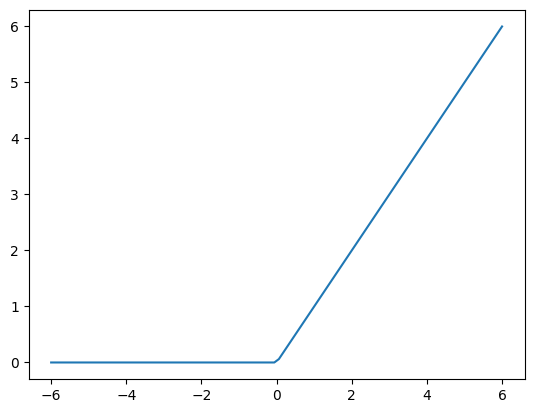

In [422]:
x = np.linspace(-6, 6, 100)

# convert from Var to ndarray  
def Var_to_nparray(x):
  y = np.zeros((len(x),len(x[0])))
  for i in range(len(x)):
    for j in range(len(x[0])):
      y[i,j] = x[i][j].v
  return y

# define 1-1 network with weight = 1 and relu activation 
NN = [ DenseLayer(1, 1, lambda x: x.relu(), initializer = ConstantInitializer(1.0)) ] 
y = Var_to_nparray(forward(nparray_to_Var(x), NN))

#y = Var_to_nparray(relu(nparray_to_Var(x)))
plt.plot(x,y)

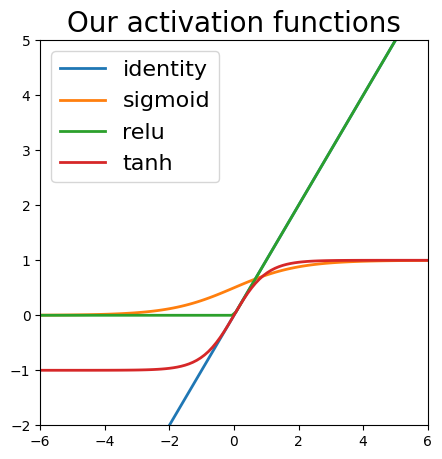

In [423]:
# Testing all activation layers

x = np.linspace(-6, 6, 100)
units = {
    "identity": lambda x: x.identity(),
    "sigmoid": lambda x: x.sigmoid(),
    "relu": lambda x: x.relu(),
    "tanh": lambda x: x.tanh()
}

plt.figure(figsize=(5, 5))
[plt.plot(x, Var_to_nparray(forward(nparray_to_Var(x), [DenseLayer(1, 1, unit, initializer = ConstantInitializer(1.0))]) ), label=unit_name, lw=2) for unit_name, unit in units.items()] # unit(nparray_to_Var(x))), label=unit_name, lw=2) for unit_name, unit in units.items()]
plt.legend(loc=2, fontsize=16)
plt.title('Our activation functions', fontsize=20)
plt.ylim([-2, 5])
plt.xlim([-6, 6])
plt.show()

# Advanced initialization schemes

If we are not careful with initialization, the signals we propagate forward ($a^{(l)}$, $l=1,\ldots,L$) and backward ($\delta^l$, $l=L,L-1,\ldots,1$) can blow up or shrink to zero. A statistical analysis of the variance of the signals for different activation functions can be found in these two papers: [Glorot initialization](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) and [He initialization](https://arxiv.org/pdf/1502.01852v1.pdf). 

The result of the analyses are proposals for how to make the initialization such that the variance of the signals (forward and backward) are kept approxmimatly constant when propagating from layer to layer. The exact expressions depend upon the non-linear activation function used. In Glorot initialization, the aim is to keep both the forward and backward variances constant whereas He only aims at keeping the variance in the forward pass constant.

We define $n_{in}$ and $n_{out}$ as the number of input units and output units of a particular layer. 

The Glorot initialization has the form: 

$$w_{ij} \sim N \bigg( 0, \, \frac{2 \alpha }{n_{in} + n_{out}} \bigg) \ . $$

where $N(\mu,\sigma^2)$ is a Gaussian distribution with mean $\mu$ and variance $\sigma^2$ and $\alpha$ is a parameter that depends upon the activation function used. For $\tanh$, $\alpha=1$ and for Rectified Linear Unit (ReLU) activations, $\alpha=2$. (It is also possible to use a uniform distribution for initialization, see [this blog post](https://mmuratarat.github.io/2019-02-25/xavier-glorot-he-weight-init).) 

The He initialization is very similar

$$w_{ij} \sim N \bigg( 0, \, \frac{\alpha}{n_{in}} \bigg) \ . $$

## Exercise i) Glorot and He initialization
 
Using the Initializer class, implement functions that implement Glorot and He 

Explain briefly how you would test numerically that these initializations have the sought after property. Hint: See plots in Glorot paper.

Comment: If you want to be more advanced then try to make a universal initializer taking both the activation function and type (Glorot or He) as argument.

In [424]:
## Glorot
def DenseLayer_Glorot_tanh(n_in: int, n_out: int):
  std = np.sqrt(2/(n_in+n_out)) # <- replace with proper initialization
  return DenseLayer(n_in, n_out, lambda x: x.tanh(), initializer = NormalInitializer(std))

## He
def DenseLayer_He_relu(n_in: int, n_out: int):
  std = np.sqrt(2/(n_in+n_out)) # <- replace with proper initialization
  return DenseLayer(n_in, n_out, lambda x: x.relu(), initializer = NormalInitializer(std))

## Exercise j) Forward pass unit test

Write a bit of code to make a unit test that the forward pass works. This can be done by defining a simple network with for example all weights equal to one (using the ConstantInitializer method) and identity activation functions. 

Hints: Use the [assert](https://www.w3schools.com/python/ref_keyword_assert.asp), the nparray_to_Var and the Var_to_nparray commands. 

In [425]:
def nparray_to_Var_test(x):
    if x.ndim == 1:
        y = [Var(float(x[i])) for i in range(x.shape[0])]
    else:
        y = [[Var(float(x[i, j])) for j in range(x.shape[1])] for i in range(x.shape[0])]
    return y

def Var_to_nparray_test(x):
    if isinstance(x[0], Var):
        y = np.array([xi.v for xi in x])
    elif isinstance(x[0], list):
        y = np.array([[xij.v for xij in xi] for xi in x])
    else:
        raise ValueError("Unsupported input type")
    return y

def forward_single(x, network):
    """Helper function to forward input x through the network."""
    for layer in network:
        x = layer.forward(x)
    return x

def test_forward_pass():
    network = [DenseLayer(2, 2, lambda x: x.identity(),initializer=ConstantInitializer(weight=1.0, bias=1.0))]
    # network = [DenseLayer_He_relu(2, 2)]
    # network = [ DenseLayer_Glorot_tanh(2, 2)]
   
    x_train = nparray_to_Var_test(np.array([1.0, 1.0]))
    output = forward_single(x_train, network)
    output_np = Var_to_nparray_test(output)

    expected_output = np.array([3.0, 3.0])

    assert np.allclose(output_np, expected_output), f"Expected {expected_output}, but got {output_np}"

    print("Test passed!")

test_forward_pass()

Test passed!


# Loss functions

We are only missing a loss function to we need to define a loss function and its derivative with respect to the output of the neural network $y$

In [426]:
def squared_loss(t, y):
  
  # add check that sizes agree
  
  def squared_loss_single(t, y):
    Loss = Var(0.0)
    for i in range(len(t)): # sum over outputs
      Loss += (t[i]-y[i]) ** 2
    return Loss

  Loss = Var(0.0)
  for n in range(len(t)): # sum over training data
    Loss += squared_loss_single(t[n],y[n])
  return Loss

## Exercise k) Implement cross entropy loss

Insert code below to implement cross-entropy loss for general dimensionality of $t$. Use a logits formulation:
$$
\rm{Loss} = - \sum_i t_i \, log \, p_i 
$$
with $p$ given by the the softmax function in terms of the logits $h$:
$$
p_i = \frac{\exp(h_i)}{\sum_{i'} \exp(h_{i'})} .
$$
Inserting $p$ in the expression for the loss gives
$$
\rm{Loss} = - \sum_i t_i h_i + \rm{LogSumExp}(h) \ ,
$$
where 
$$
\rm{LogSumExp}(h) = \log \sum_i \exp h_i \ .
$$
This is true for $t$ being a one-hot vector. 

Call the function to convince yourself it works. 

In practice you want to implement a [numerically stable](https://leimao.github.io/blog/LogSumExp/) version of LogSumExp. But we will not bother about that here.

Help: You can add these methods in the Var class:

    def exp(self):
        return Var(exp(self.v), lambda: [(self, exp(self.v))])
    
    def log(self):
        return Var(log(self.v), lambda: [(self, self.v ** -1)])

In [427]:
def cross_entropy_loss(t, h):
    Loss=log(np.sum(h))
    for i in range(len(t)):
        Loss=Loss-t[i]*h[i]
   
    # Insert code here
    return Loss


# print(cross_entropy_loss(x,y))

# Backward pass

Now the magic happens! We get the calculation of the gradients for free. Just do:

In [428]:
NN = [
    DenseLayer(1, 5, lambda x: x.relu()),
    DenseLayer(5, 1, lambda x: x.identity())
]

output = forward(x_train, NN)

Loss = squared_loss(y_train,output)
Loss.backward()

and the gradients will be calculated:

In [429]:
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

Layer 0 
 Weights: [[Var(v=0.0520, grad=-9.4198), Var(v=0.0942, grad=-6.4147), Var(v=0.0322, grad=-7.3788), Var(v=-0.1006, grad=2.6815), Var(v=-0.0083, grad=-3.7763)]] Biases: [Var(v=0.0000, grad=-8.0938), Var(v=0.0000, grad=-5.5117), Var(v=0.0000, grad=-6.3402), Var(v=0.0000, grad=-2.4373), Var(v=0.0000, grad=3.4323)]
Layer 1 
 Weights: [[Var(v=0.0941, grad=-5.2088)], [Var(v=0.0641, grad=-9.4358)], [Var(v=0.0737, grad=-3.2229)], [Var(v=-0.0280, grad=9.6341)], [Var(v=0.0394, grad=0.7918)]] Biases: [Var(v=0.0000, grad=1.0013)]


[None, None]

# Backward pass unit test

Above we used finite differences to test that Nanograd is actually doing what it is supposed to do. We can in principle try the same for the neural network. But we will trust that the test above is enough.

# Training and validation

We are ready to train some neural networks!

We initialize again:

In [430]:
NN = [
    DenseLayer(1, 15, lambda x: x.relu()),
    DenseLayer(15, 50, lambda x: x.relu()),
    DenseLayer(50, 1, lambda x: x.identity())
]

output = forward(x_train, NN)

Loss = squared_loss(y_train,output)
Loss.backward()

and make an update:

We introduce a help function parameters to have a handle in all parameters in the network.

In [431]:
print('Network before update:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

def parameters(network):
  params = []
  for layer in range(len(network)):
    params += network[layer].parameters()
  return params

def update_parameters(params, learning_rate=0.01):
  for p in params:
    p.v -= learning_rate*p.grad

def zero_gradients(params):
  for p in params:
    p.grad = 0.0

update_parameters(parameters(NN))

print('\nNetwork after update:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

zero_gradients(parameters(NN))

print('\nNetwork after zeroing gradients:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

Network before update:
Layer 0 
 Weights: [[Var(v=0.0438, grad=3.7182), Var(v=-0.0014, grad=-2.6767), Var(v=0.1294, grad=-9.0731), Var(v=-0.0248, grad=-1.9850), Var(v=0.0151, grad=0.2704), Var(v=-0.0054, grad=16.8504), Var(v=-0.0461, grad=3.1472), Var(v=-0.0619, grad=-3.2491), Var(v=-0.0239, grad=-6.2624), Var(v=-0.0790, grad=0.4187), Var(v=0.0105, grad=-3.9346), Var(v=-0.0494, grad=3.7396), Var(v=-0.0009, grad=-2.0674), Var(v=0.2224, grad=-12.3443), Var(v=0.0941, grad=-4.0247)]] Biases: [Var(v=0.0000, grad=3.1969), Var(v=0.0000, grad=2.4330), Var(v=0.0000, grad=-7.8009), Var(v=0.0000, grad=1.8042), Var(v=0.0000, grad=0.2325), Var(v=0.0000, grad=-15.3160), Var(v=0.0000, grad=-2.8606), Var(v=0.0000, grad=2.9532), Var(v=0.0000, grad=5.6922), Var(v=0.0000, grad=-0.3806), Var(v=0.0000, grad=-3.3829), Var(v=0.0000, grad=-3.3991), Var(v=0.0000, grad=1.8791), Var(v=0.0000, grad=-10.6135), Var(v=0.0000, grad=-3.4604)]
Layer 1 
 Weights: [[Var(v=0.0269, grad=0.0000), Var(v=-0.0614, grad=0.0000)

[None, None, None]

In [432]:
# Initialize an arbitrary neural network
NN = [
    DenseLayer(1, 8, lambda x: x.relu()),
    DenseLayer(8, 1, lambda x: x.identity())
]

# Recommended hyper-parameters for 3-D: 
#NN = [
#    DenseLayer(3, 16, lambda x: x.relu()),
#    DenseLayer(16, 1, lambda x: x.identity())
#]


### Notice that, when we switch from tanh to relu activation, we decrease the learning rate. This is due the stability of the gradients 
## of the activation functions.

In [433]:
# Initialize training hyperparameters
EPOCHS = 200
LEARN_R = 2e-3 

In [434]:
train_loss = []
val_loss = []

for e in range(EPOCHS):
     
    # Forward pass and loss computation
    Loss = squared_loss(y_train, forward(x_train, NN))

    # Backward pass
    Loss.backward()
    
    # gradient descent update
    update_parameters(parameters(NN), LEARN_R)
    zero_gradients(parameters(NN))
    
    # Training loss
    train_loss.append(Loss.v)
    
    # Validation
    Loss_validation = squared_loss(y_validation, forward(x_validation, NN))
    val_loss.append(Loss_validation.v)
    
    if e%10==0:
        print("{:4d}".format(e),
              "({:5.2f}%)".format(e/EPOCHS*100), 
              "Train loss: {:4.3f} \t Validation loss: {:4.3f}".format(train_loss[-1], val_loss[-1]))
        


   0 ( 0.00%) Train loss: 109.724 	 Validation loss: 108.793
  10 ( 5.00%) Train loss: 28.528 	 Validation loss: 19.612
  20 (10.00%) Train loss: 14.415 	 Validation loss: 10.707
  30 (15.00%) Train loss: 14.036 	 Validation loss: 10.487
  40 (20.00%) Train loss: 13.664 	 Validation loss: 10.253
  50 (25.00%) Train loss: 13.156 	 Validation loss: 9.952
  60 (30.00%) Train loss: 12.660 	 Validation loss: 9.635
  70 (35.00%) Train loss: 12.368 	 Validation loss: 9.422
  80 (40.00%) Train loss: 12.196 	 Validation loss: 9.341
  90 (45.00%) Train loss: 12.064 	 Validation loss: 9.288
 100 (50.00%) Train loss: 11.972 	 Validation loss: 9.224
 110 (55.00%) Train loss: 11.927 	 Validation loss: 9.180
 120 (60.00%) Train loss: 11.899 	 Validation loss: 9.139
 130 (65.00%) Train loss: 11.884 	 Validation loss: 9.107
 140 (70.00%) Train loss: 11.876 	 Validation loss: 9.081
 150 (75.00%) Train loss: 11.871 	 Validation loss: 9.062
 160 (80.00%) Train loss: 11.867 	 Validation loss: 9.047
 170 (8

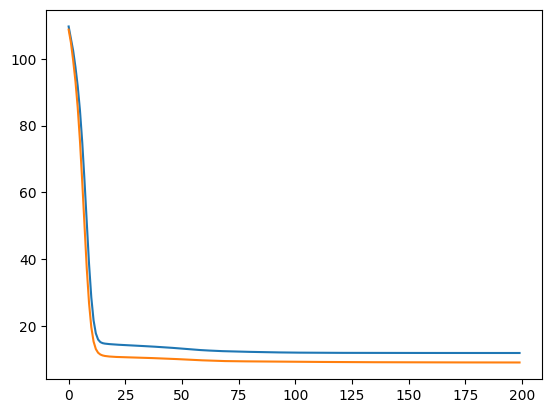

In [435]:
plt.plot(range(len(train_loss)), train_loss);
plt.plot(range(len(val_loss)), val_loss);

# Testing

We have kept the calculation of the test error separate in order to emphasize that you should not use the test set in optimization.

In [436]:
output_test = forward(x_test, NN)

Test loss:  9.815


<>:5: SyntaxWarning: invalid escape sequence '\h'
<>:5: SyntaxWarning: invalid escape sequence '\h'
C:\Users\adity\AppData\Local\Temp\ipykernel_5360\1194488628.py:5: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel("$\hat{y}$");


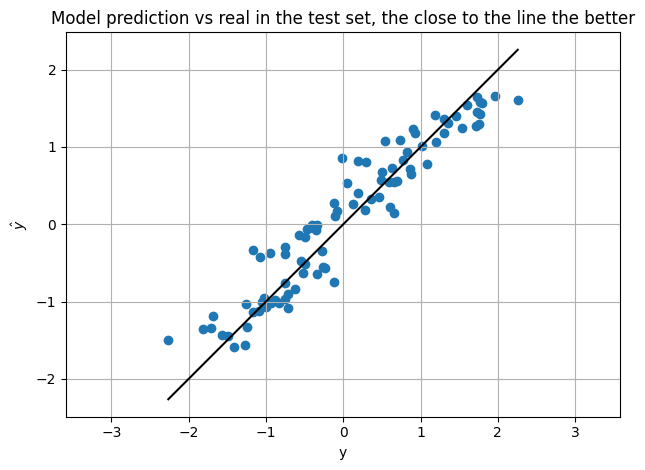

In [437]:
y_test_np = Var_to_nparray(y_test)
plt.scatter(y_test_np, Var_to_nparray(output_test));
plt.plot([np.min(y_test_np), np.max(y_test_np)], [np.min(y_test_np), np.max(y_test_np)], color='k');
plt.xlabel("y");
plt.ylabel("$\hat{y}$");
plt.title("Model prediction vs real in the test set, the close to the line the better")
plt.grid(True);
plt.axis('equal');
plt.tight_layout();

Loss_test = squared_loss(y_test, forward(x_test, NN))

print("Test loss:  {:4.3f}".format(Loss_test.v))

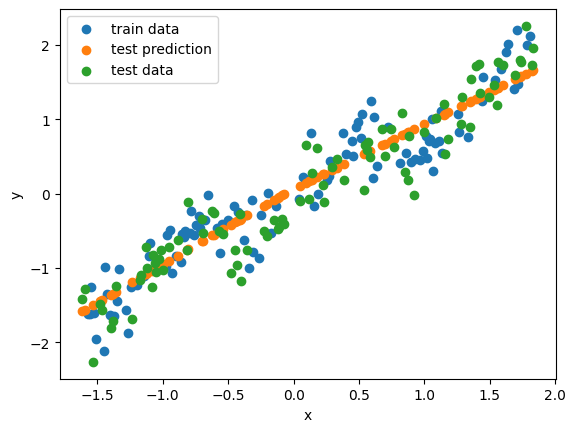

In [438]:
x_test_np = Var_to_nparray(x_test)
x_train_np = Var_to_nparray(x_train)
y_train_np = Var_to_nparray(y_train)
if D1:
    plt.scatter(x_train_np, y_train_np, label="train data");
    plt.scatter(x_test_np, Var_to_nparray(output_test), label="test prediction");
    plt.scatter(x_test_np, y_test_np, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");
else:
    plt.scatter(x_train_np[:,1], y_train, label="train data");
    plt.scatter(x_test_np[:,1], Var_to_nparray(output_test), label="test data prediction");
    plt.scatter(x_test_np[:,1], y_test_np, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");

## Exercise l) Show overfitting, underfitting and just right fitting

Vary the architecture and other things to show clear signs of overfitting (=training loss significantly lower than test loss) and underfitting (=not fitting enoung to training data so that test performance is also hurt).

See also if you can get a good compromise which leads to a low validation loss. 

For this problem do you see any big difference between validation and test loss? The answer here will probably be no. Discuss cases where it is important to keep the two separate.

_Insert written answer here._


<>:91: SyntaxWarning: invalid escape sequence '\h'
<>:91: SyntaxWarning: invalid escape sequence '\h'
C:\Users\adity\AppData\Local\Temp\ipykernel_5360\3448543542.py:91: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel("$\hat{y}$");


   0 ( 0.00%) Train loss: 8.674 	 Validation loss: 12.612
  10 ( 5.00%) Train loss: 7.410 	 Validation loss: 11.894
  20 (10.00%) Train loss: 6.775 	 Validation loss: 10.983
  30 (15.00%) Train loss: 6.329 	 Validation loss: 10.247
  40 (20.00%) Train loss: 5.973 	 Validation loss: 9.669
  50 (25.00%) Train loss: 5.643 	 Validation loss: 9.161
  60 (30.00%) Train loss: 5.387 	 Validation loss: 8.798
  70 (35.00%) Train loss: 5.220 	 Validation loss: 8.543
  80 (40.00%) Train loss: 5.085 	 Validation loss: 8.371
  90 (45.00%) Train loss: 4.971 	 Validation loss: 8.247
 100 (50.00%) Train loss: 4.893 	 Validation loss: 8.174
 110 (55.00%) Train loss: 4.843 	 Validation loss: 8.120
 120 (60.00%) Train loss: 4.813 	 Validation loss: 8.062
 130 (65.00%) Train loss: 4.795 	 Validation loss: 7.983
 140 (70.00%) Train loss: 4.783 	 Validation loss: 7.927
 150 (75.00%) Train loss: 4.774 	 Validation loss: 7.907
 160 (80.00%) Train loss: 4.765 	 Validation loss: 7.886
 170 (85.00%) Train loss: 4

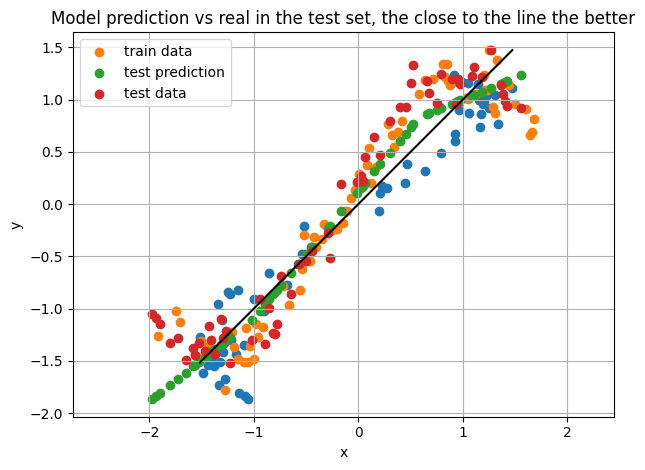

In [439]:
# Insert your code for getting overfitting, underfitting and just right fitting

def data_generator1(noise=0.1, n_samples=300, D1=True):
    # Create covariates and response variable
    if D1:
        X = np.linspace(-3, 3, num=n_samples).reshape(-1,1) # 1-D
        np.random.shuffle(X)
        y = np.random.normal((3*np.sin(X[:,0]*1) + X[:,0]), noise) # 1-D with trend
    else:
        pass

    # Stack them together vertically to split data set
    data_set = np.vstack((X.T,y)).T
    
    train, validation, test = np.split(data_set, [int(0.35*n_samples), int(0.7*n_samples)], axis=0)
    
    # Standardization of the data, remember we do the standardization with the training set mean and standard deviation
    train_mu = np.mean(train, axis=0)
    train_sigma = np.std(train, axis=0)
    
    train = (train-train_mu)/train_sigma
    validation = (validation-train_mu)/train_sigma
    test = (test-train_mu)/train_sigma
    
    x_train, x_validation, x_test = train[:,:-1], validation[:,:-1], test[:,:-1]
    y_train, y_validation, y_test = train[:,-1], validation[:,-1], test[:,-1]

    return x_train, y_train,  x_validation, y_validation, x_test, y_test
x_train, y_train,  x_validation, y_validation, x_test, y_test = data_generator1(noise=0.5, n_samples=200,D1=True)
x_train = nparray_to_Var(x_train)
y_train = nparray_to_Var(y_train)
x_validation = nparray_to_Var(x_validation)
y_validation = nparray_to_Var(y_validation)
x_test = nparray_to_Var(x_test)
y_test = nparray_to_Var(y_test)

# # Network for Overfitting

# NN = [
#     DenseLayer(1, 5, lambda x: x.sigmoid()),
#     DenseLayer(5, 5, lambda x: x.tanh()),
#     DenseLayer(5, 1, lambda x: x.identity())
# ]
# # Network for rightfitting


# NN = [

#     DenseLayer(1, 5, lambda x: x.sigmoid()),
#     DenseLayer(5, 1, lambda x: x.identity())
# ]

# # Network for underfitting

# NN = [

#     DenseLayer(1, 1, lambda x: x.identity())
# ]
train_loss = []
val_loss = []

for e in range(EPOCHS):
     
    # Forward pass and loss computation
    Loss = squared_loss(y_train, forward(x_train, NN))

    # Backward pass
    Loss.backward()
    
    # gradient descent update
    update_parameters(parameters(NN), LEARN_R)
    zero_gradients(parameters(NN))
    
    # Training loss
    train_loss.append(Loss.v)
    
    # Validation
    Loss_validation = squared_loss(y_validation, forward(x_validation, NN))
    val_loss.append(Loss_validation.v)
    
    if e%10==0:
        print("{:4d}".format(e),
              "({:5.2f}%)".format(e/EPOCHS*100), 
              "Train loss: {:4.3f} \t Validation loss: {:4.3f}".format(train_loss[-1], val_loss[-1]))
        
output_test = forward(x_test, NN)
y_test_np = Var_to_nparray(y_test)
plt.scatter(y_test_np, Var_to_nparray(output_test));
plt.plot([np.min(y_test_np), np.max(y_test_np)], [np.min(y_test_np), np.max(y_test_np)], color='k');
plt.xlabel("y");
plt.ylabel("$\hat{y}$");
plt.title("Model prediction vs real in the test set, the close to the line the better")
plt.grid(True);
plt.axis('equal');
plt.tight_layout();

Loss_test = squared_loss(y_test, forward(x_test, NN))

print("Test loss:  {:4.3f}".format(Loss_test.v))
x_test_np = Var_to_nparray(x_test)
x_train_np = Var_to_nparray(x_train)
y_train_np = Var_to_nparray(y_train)
if D1:
    plt.scatter(x_train_np, y_train_np, label="train data");
    plt.scatter(x_test_np, Var_to_nparray(output_test), label="test prediction");
    plt.scatter(x_test_np, y_test_np, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");
else:
    plt.scatter(x_train_np[:,1], y_train, label="train data");
    plt.scatter(x_test_np[:,1], Var_to_nparray(output_test), label="test data prediction");
    plt.scatter(x_test_np[:,1], y_test_np, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");
        